### A8: Generative Models 生成式模型
------

authored by `张瀚墨2021213368`
github：`hammershock`

------

- 在上个章节中，我们复现了自动编码器及其变种。`自动编码机(AutoEncoders)`通过学习y=x的恒等变换实现在无监督训练自动提取特征。自动编码机的变种，包括`稀疏自动编码机（SparseAEs）`、`去噪自动编码机（DenoisingAEs）`，通过训练技巧提升了编码的稀疏性和鲁棒性。这一类常常被用于特征提取和降维任务。但是对于生成任务而言，他们并不合适，原因在于原始数据分布在编码器复杂非线性变换的投射下未必是规则的，这不利于我们在生成采样时令解码器得到有意义的结果。
- 变分自动编码机（VAE），借鉴了贝叶斯方法中的变分推断技术，在训练模型学习恒等变换的同时通过引入对编码空间的KL散度进行正则化，使得编码空间在编码过程中保持良好的规范性，有利于在编码空间的采样与插值。
- VAE也可以实现一种有监督的变种：条件变分自动编码机（ConditionalVAE，CVAE），可引入标签数据，实现有标签的生成任务。

VAE的原理：
- 首先，它在AutoEncoder的基础上，假定编码器的结果是一个高斯分布，用于近似后验条件分布P(z|x)，前向传播时对它的均值与方差进行预测。
- VAEs在训练时采用重参数化技巧，计算z=mu + std * eps, （eps从高斯分布上采样得到），使得梯度可以顺利回传至编码器。
- 使用重构误差（y与x的误差）和编码空间的KL散度损失同时对模型进行约束。

本实验工作内容如下：
- 以`CIFAR-10`、`MNIST`、`fashion_mnist`、`SVHN`和`CelebA`数据集为例，展示条件变分自动编码机（ConditionalVAE，CVAE）的训练评估和用于生成任务时的插值与采样
- 提供了美丽的UI界面，用于展示潜在空间的连续性
- 复现了CVAE作为贝叶斯模型，在训练时遇到的“后验坍缩”问题

ps.如果去掉模型中的标签嵌入，就可以看作是不包含条件的普通VAE。这里就不给出普通VAE的实现了

☀️运行demo app☀️:

In [23]:
!python app.py

在实验开始之前，先看效果展示：
![demo_app1.gif](assets%2Fdemo_app1.gif)

![demo_app2.gif](assets%2Fdemo_app2.gif)

![demo_app3.gif](assets%2Fdemo_app3.gif)

![demo_app4.gif](assets%2Fdemo_app4.gif)

![demo_app5.gif](assets%2Fdemo_app5.gif)

### 零、安装依赖

In [1]:
!pip install torch torchvision
!pip install numpy
!pip install matplotlib
!pip install tqdm


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


### 一、导入模块

In [1]:
import os
from enum import Enum

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [17]:
class ConditionalConvVAE(nn.Module):
    """
    条件全卷积VAE变分自动编码器
    """
    NAME = 'ConditionalConvVAE'
    
    def __init__(self, potential_dim, channels, num_classes=10):
        super(ConditionalConvVAE, self).__init__()
        self.potential_dim = potential_dim
        self.channels = channels
        
        # 对类别标签进行编码的线性层
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        
        # 卷积输出形状：
        # output_size = [(input_size - kernel_size + 2 * padding)/stride] + 1
        # 反卷积输出形状：
        # output_size = (input_size - 1) * stride -2 * padding + kernel_Size + output_padding
        self.encoder = nn.Sequential(
            nn.Conv2d(channels + num_classes, 128, kernel_size=3, stride=2, padding=1),  # 16
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),  # 8
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),  # 4
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),  # 2
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),  # 1
            nn.Flatten(),
        )
        
        output_shape = (128, 1, 1)
        output_dim = output_shape[0] * output_shape[1] * output_shape[2]
        
        self.enc_mu = nn.Linear(output_dim, potential_dim)     # 均值
        self.enc_log_var = nn.Linear(output_dim, potential_dim) # 对数方差
        # 解码器
        self.decoder_fc = nn.Linear(potential_dim + num_classes, output_dim)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, output_shape),  # 1
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),  # 2
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),  # 4
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),  # 8
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),  # 16
            nn.ConvTranspose2d(128, channels, kernel_size=3, stride=2, padding=1, output_padding=1), 
            # nn.AdaptiveAvgPool2d((178, 218)),
            nn.Sigmoid()  # 32
        )

    def encode(self, x, labels):
        # 将标签嵌入到与图像相同的维度
        # 如果不添加标签嵌入，就可以看作是不包含条件的普通VAE
        labels = self.label_embedding(labels).unsqueeze(2).unsqueeze(3)  # (128, 10, 1, 1)
        labels = labels.expand(labels.size(0), labels.size(1), x.size(2), x.size(3))  # (128, 10, 32, 32)
        
        # 将标签和图像连接起来
        x = torch.cat((x, labels), dim=1)  # (128, 11, 32, 32)
        
        # 传入编码器
        x = self.encoder(x)
        mu = self.enc_mu(x)
        log_var = self.enc_log_var(x)
        
        # 重参数化
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        
        return z, mu, log_var

    def decode(self, z, labels):
        # 将标签嵌入并与潜在向量连接起来
        labels = self.label_embedding(labels)
        z = torch.cat((z, labels), dim=1)

        # 传入解码器
        x = self.decoder_fc(z)
        x = self.decoder(x)
        return x

    def forward(self, x, labels):
        z, mu, log_var = self.encode(x, labels)
        reconstructed_x = self.decode(z, labels)
        return reconstructed_x, mu, log_var


# 定义损失函数
def vae_loss(recon_x, x, mu, log_var):
    # 重构损失：通常使用二元交叉熵（BCE）损失
    MSE = nn.functional.mse_loss(recon_x.view(-1, 32*32), x.view(-1, 32*32), reduction='sum')
    # KL 散度损失：用于度量学到的潜在分布与标准正态分布之间的差异
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    loss = MSE + KLD
    return loss, np.array([loss.item(), MSE.item(), KLD.item()])


class DatasetType(Enum):
    cifar10 = 'cifar10'
    mnist = 'mnist'
    fashion_mnist = 'fashion_mnist'
    svhn = 'svhn'
    celeba = 'celeba'

### 三、模型训练

In [18]:
# 查看可用的训练设备
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

#### 指定你自己的训练参数，配置数据集

In [19]:
# ----------------------- 训练配置 ----------------------- 
batch_size = 128
epochs = 50
potential_dim = 8
lr = 0.001
# 这里支持DatasetType中除了celebA数据集之外的所有数据集的训练，因为他在处理标签的方式有略微不同
dataset_type = DatasetType.mnist  # 在这里设置你的数据集
# ------------------------------------------------------- 

In [20]:
# 其他参数
MODEL_PATH = f'models/cvae_{dataset_type.value}.pth'
os.makedirs('history', exist_ok=True)
HISTORY_PATH = f'history/cvae_{dataset_type.value}_history.npy'
CHANNELS = 1 if dataset_type in [DatasetType.mnist, DatasetType.fashion_mnist] else 3

# 模型和优化器
vae = ConditionalConvVAE(potential_dim=potential_dim, channels=CHANNELS)
vae.to(device)

running_losses = []
if os.path.exists(MODEL_PATH):
    try:
        vae.load_state_dict(torch.load(MODEL_PATH))  # 加载模型
        running_losses = list(np.load(HISTORY_PATH)) if os.path.exists(HISTORY_PATH) else []  # 加载训练历史
    except RuntimeError:  # 在加载模型上遇到错误
        pass
    
    
def generate_and_record_images(step):
    z = torch.randn(10, vae.potential_dim).to(device)
    with torch.no_grad():
        labels = torch.LongTensor(np.arange(10)).to(device)
        # 通过解码器生成图像
        generated_images = vae.decode(z, labels)  # (10, 1, 28, 28)
        for i, image in enumerate(generated_images):
            if image.shape[0] == 1:
                image = image.repeat(3, 1, 1)
            writer.add_image('Generated Image', image, global_step=10 * step + i)

In [21]:
# 模型训练

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# 加载数据集
if dataset_type == DatasetType.mnist:
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
elif dataset_type == DatasetType.cifar10:
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
elif dataset_type == DatasetType.fashion_mnist:
    train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
elif dataset_type == DatasetType.svhn:
    train_dataset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
else:
    raise NotImplementedError

optimizer = optim.Adam(vae.parameters(), lr=lr)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

writer = SummaryWriter('runs/GAN_experiment')

p_bar = tqdm(range(epochs))

# 开始训练
for epoch in p_bar:
    running_loss = np.array([0., 0., 0.])
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = vae(data, labels)
        loss, losses = vae_loss(recon_batch, data, mu, log_var)
        loss.backward()
        
        optimizer.step()
        running_loss += 1/(batch_idx + 1) * (losses - running_loss)
        p_bar.set_postfix(progress=f'{(batch_idx+1)/len(train_loader)*100:.2f}%', totalLoss=f'{running_loss[0]:.3f}', MSELoss=f'{running_loss[1]:.3f}', KLDLoss=f'{running_loss[2]:.3f}')
        
    writer.add_scalar('Loss/total', running_loss[0], epoch)
    writer.add_scalar('Loss/mse', running_loss[1], epoch)
    writer.add_scalar('Loss/kld', running_loss[2], epoch)
    generate_and_record_images(epoch)
    running_losses.append(running_loss)
    np.save(HISTORY_PATH, np.array(running_losses))
    torch.save(vae.state_dict(), MODEL_PATH)

 28%|██▊       | 14/50 [01:25<03:40,  6.13s/it, KLDLoss=763.577, MSELoss=2426.571, progress=59.06%, totalLoss=3190.149] 


KeyboardInterrupt: 

### 四、绘制损失曲线

[3195.81214967 2433.71324304  762.09890871]


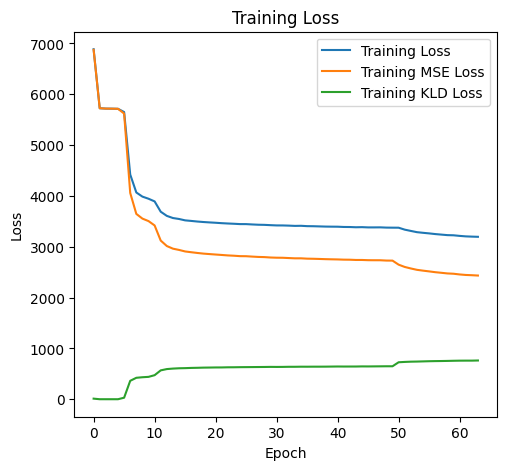

In [22]:
plt.figure(figsize=(12, 5))
total_loss, bce_loss, kld_loss = np.array(running_losses).T
# 绘制损失
plt.subplot(1, 2, 1)
plt.plot(total_loss, label='Training Loss')
plt.plot(bce_loss, label='Training MSE Loss')
plt.plot(kld_loss, label='Training KLD Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
print(running_losses[-1])

### 五、模型推理

In [7]:
def generate(model, labels, device='cuda'):
    with torch.no_grad():
        num_samples = len(labels)
        z = torch.randn(num_samples, model.potential_dim).to(device)
        labels = torch.LongTensor(np.array(labels)).to(device)
        # 通过解码器生成图像
        generated_images = model.decode(z, labels)
    return generated_images

def plot(images):
    plt.figure(figsize=(8, 8))
    channels = images.size(1)
    for i, image in enumerate(images):
        plt.subplot(8, 8, i+1)
        img = image.squeeze().cpu().numpy()
        if channels == 3:
            img = np.transpose(img, (2, 1, 0))
            
        plt.imshow(img, cmap='gray' if channels == 1 else None)
        plt.axis('off')
    plt.show()

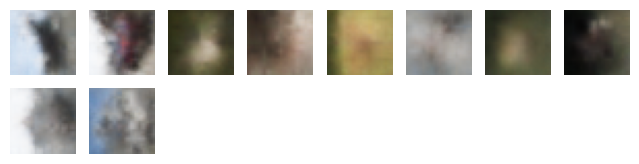

In [15]:
images = generate(vae, list(range(10)), device)
plot(images)

### 附加题1：条件生成网络与普通生成网络比较分析

#### 实验设置
使用相同的数据集比如`CIFAR-10`，训练一个CVAE模型和一个普通VAE模型。

#### 比较分析
1. **生成图像的质量**：比较两种模型生成的图像质量。通常，条件生成模型（CVAE）因为有额外的信息（如类别标签），可能会生成更清晰、更准确的图像。

2. **多样性和创新性**：分析两种模型生成图像的多样性。无条件模型可能在多样性方面表现更好，因为它不受任何条件的限制。

3. **学习的特征和模式**：研究两种模型学习的特征和模式。条件模型可能会学习到与特定条件（如类别）更相关的特征。

### 附加题2：思考并定义一个图像生成问题，通过调研目前存在的方法和策略，设计相应的解决方法，并分析方法的可行性以及创新性。
### 问题定义：生成特定风格的服装设计图像

#### 目标
开发一个生成模型，能够根据文本描述（如风格、颜色、款式等）生成相应的服装设计图像。这种模型可以帮助设计师快速实现创意，并为非专业人士提供一种定制服装设计的工具。

#### 应用场景
- 服装设计师可以使用它来快速原型化和迭代设计想法。
- 电子商务平台可以提供个性化的服装设计服务。
- 时尚爱好者可以用它来探索和创建自己的服装风格。

### 方法设计

#### 1. 模型架构
- **文本编码器**：使用Transformer Encoder或BERT-like模型对输入的文本进行编码。这些模型能够理解文本中的复杂语义和上下文信息。
- **图像生成器**：使用条件生成对抗网络（Conditional GAN）或变分自动编码器（VAE）。这里的条件是从文本编码器得到的上下文向量。

#### 2. 数据集准备
- **收集数据**：获取大量的服装图像及其描述。可以从在线时尚网站、服装目录或社交媒体平台收集数据。
- **数据注释**：为每张图像添加详细的文本描述，包括风格、颜色、材料等信息。

#### 3. 训练流程
- **联合训练**：同时训练文本编码器和图像生成器，使得模型能够理解文本描述与生成图像之间的关联。
- **损失函数**：对于生成器，使用生成对抗网络的判别器损失，以及适用于图像生成的其他损失（如像素级损失）。

#### 4. 模型优化
- **文本编码器优化**：考虑使用预训练的NLP模型以提高文本理解能力。
- **图像质量优化**：考虑使用更复杂的图像生成网络，如StyleGAN，以提高生成图像的质量和实用性。

#### 5. 用户界面
- **交互设计**：开发一个用户友好的界面，让用户输入文本描述并查看生成的服装图像。
- **实时反馈**：允许用户调整描述，以实时看到修改后的生成图像。

### 可行性与创新性分析

#### 可行性
- **技术成熟度**：文本到图像的生成技术已经在多个领域取得了显著进展，说明这种方法在技术上是可行的。
- **数据可获得性**：互联网上有大量的服装图像和描述，使得构建数据集成为可能。

#### 创新性
- **个性化设计**：这种方法可以根据用户的具体描述生成个性化的服装设计，提供高度定制化的体验。
- **设计灵感工具**：该模型可以作为一个创意工具，帮助设计师快速将想法转化为可视化设计。

#### 挑战
- **文本到图像的准确性**：确保文本描述准确转化为视觉元素是一个挑战。
- **图像质量**：生成高质量、真实感强的图像仍然是一大挑战。